In [1]:
import baccoemu
import chainconsumer
import dynesty
import gc
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count

import emcee
import os
import pandas as pd
import time

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
#import sbi_tools
import plot_utils
#import scripts
# from scripts import sbi_tools
#from scripts import plot_utils
import generate_emuPks as genP

from momentnetworks import demo

%load_ext autoreload
%autoreload 2

2024-02-22 17:44:54.152254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plot_dir = '../plots/plots_2024-02-19'
save_plots = True

tag_fit = '_cosmolib'

In [3]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

48 CPUs


In [4]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'
#N_threads = sbi_tools.set_N_threads(6)

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Load data

In [65]:
tag_emuPk = '_2param'

fn_emuPk = f'../data/emuPks/emuPks{tag_emuPk}.npy'
fn_emuPk_params = f'../data/emuPks/emuPks_params{tag_emuPk}.txt'
fn_emuk = f'../data/emuPks/emuPks_k{tag_emuPk}.txt'
fn_emuPkerrG = f'../data/emuPks/emuPks_errgaussian_{tag_emuPk}.npy'

Pk_noiseless = np.load(fn_emuPk)
gaussian_error_pk = np.load(fn_emuPkerrG)
theta = np.genfromtxt(fn_emuPk_params, delimiter=',', names=True)
param_names = theta.dtype.names
# from tuples to 2d array
theta = np.array([list(tup) for tup in theta])
kk = np.genfromtxt(fn_emuk)

In [66]:
param_label_dict = {'omega_cold': r'$\Omega_\mathrm{m}$',
                'sigma8_cold': r'$\sigma_{8}$',
                'sigma_8': r'$\sigma_{8}$',
                'hubble': r'$h$',
                'h': r'$h$',
                'ns': r'$n_\mathrm{s}$',
                'n_s': r'$n_\mathrm{s}$',
                'omega_baryon': r'$\Omega_\mathrm{b}$',}
param_labels = [param_label_dict[param_name] for param_name in param_names]
extents = [dict_bounds[param_name] for param_name in param_names]

In [67]:
n_tot = theta.shape[0]
n_params = theta.shape[1]

In [68]:
print(Pk_noiseless.shape, theta.shape, gaussian_error_pk.shape)

(1000, 30) (1000, 2) (1000, 30)


Add some error!

In [69]:
rng = np.random.default_rng(42)
Pk = rng.normal(Pk_noiseless, gaussian_error_pk)
# Pk = []
# for i in range(n_tot):
#     pk = rng.normal(Pk_noiseless[i], gaussian_error_pk[i])
#     Pk.append(Pk)
# Pk = np.array(Pk)
print(Pk.shape)

(1000, 30)


Plot P(k) data:

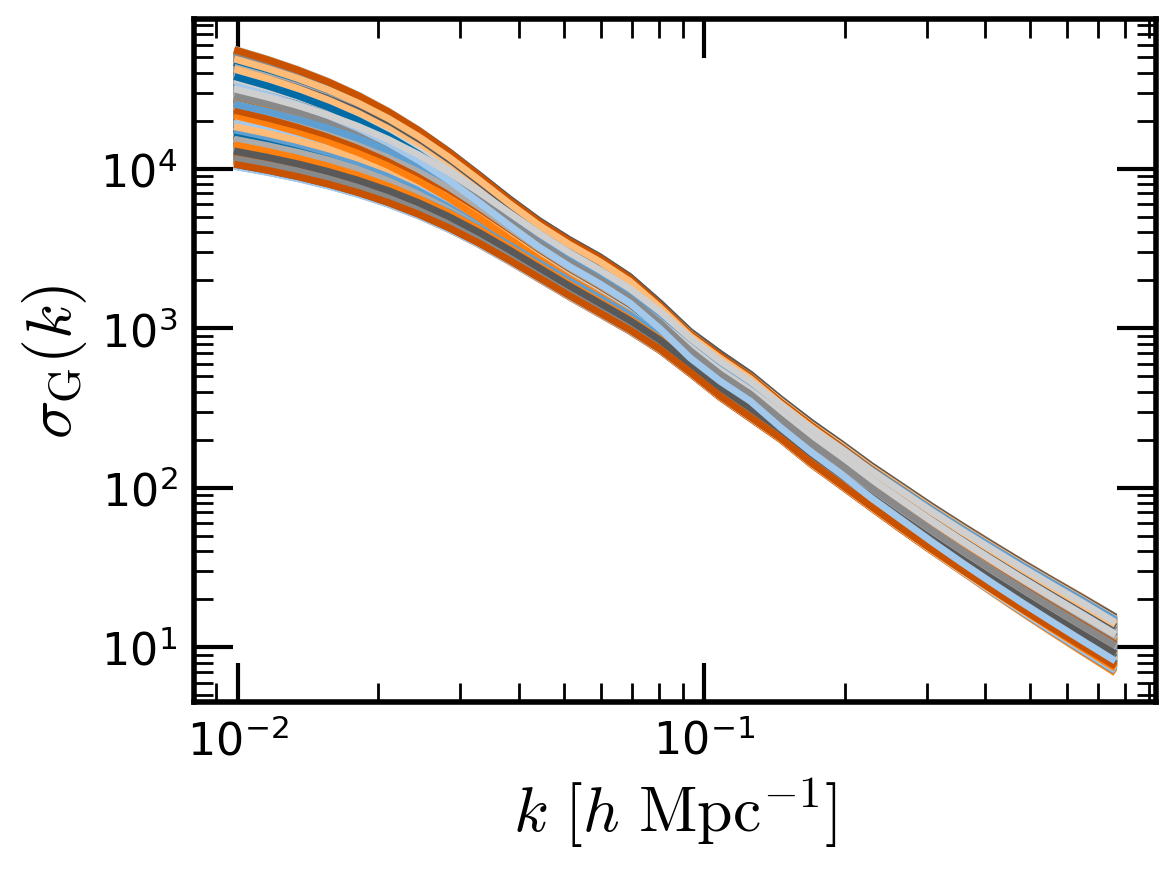

In [70]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 4.5))
for iLH in range(n_tot):
    ax.loglog(kk, gaussian_error_pk[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$\sigma_\text{G}(k)$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

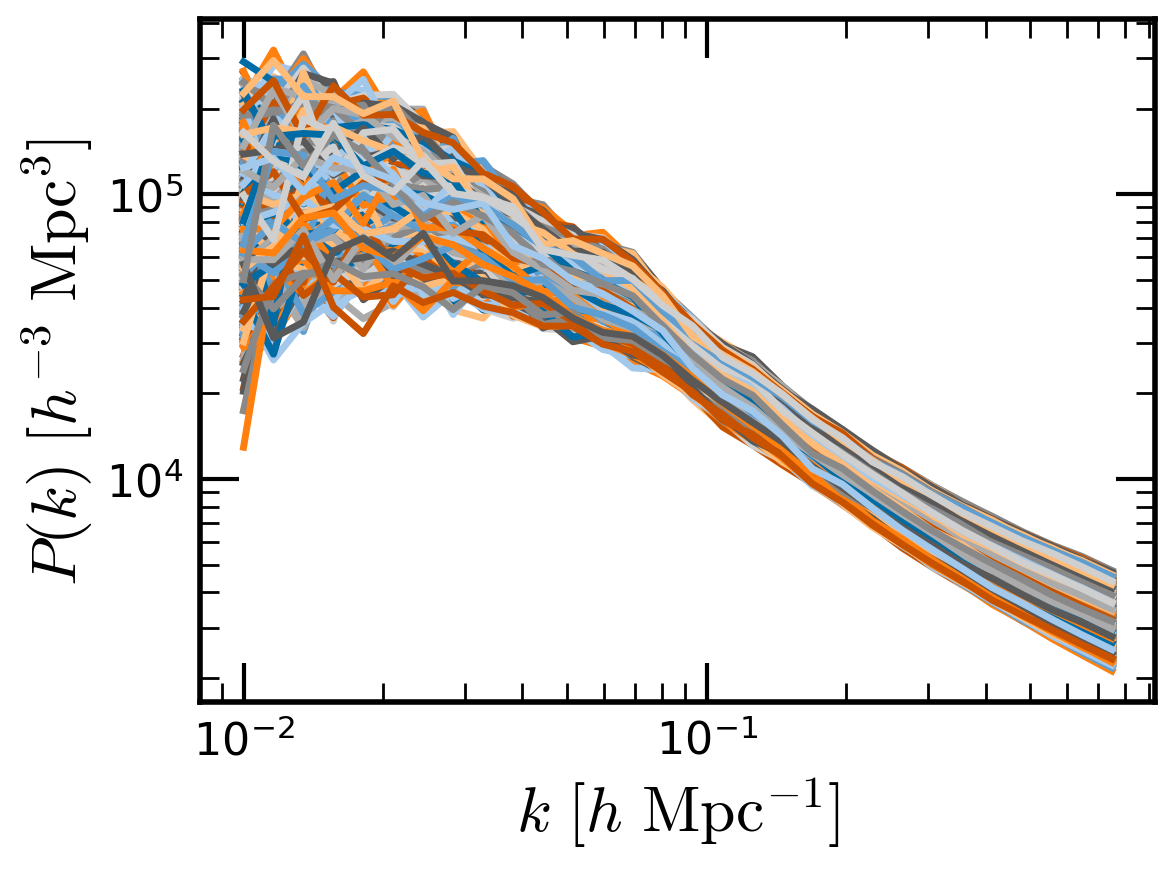

In [71]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 4.5))
for iLH in range(n_tot):
    ax.loglog(kk, Pk[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [72]:
#n_biasmodels = len(biases_vec)
n_biasmodels = 0
n_cosmos = n_params
print(n_biasmodels, n_cosmos)

0 2


Split into train-val-test

In [73]:
p_train, p_test = 0.8, 0.1
p_val = 1-p_train-p_test
train_split = int(theta.shape[0]*p_train)
test_split = int(theta.shape[0]*(1-p_test))
#train_val_split = int(n_biasmodels*round(theta.shape[0]*0.99/n_biasmodels))

theta_train = theta[:train_split]
theta_val = theta[train_split:test_split]
theta_test = theta[test_split:]
print(theta_train.shape, theta_val.shape, theta_test.shape)

(800, 2) (100, 2) (100, 2)


In [74]:
Pk_train = Pk[:train_split]
Pk_val = Pk[train_split:test_split]
Pk_test = Pk[test_split:]

mask = np.all(Pk_train>0, axis=0)
Pk_train = Pk_train[:,mask]
Pk_val = Pk_val[:,mask]
Pk_test = Pk_test[:,mask]
k = kk[mask]

gaussian_error_pk_train = gaussian_error_pk[:train_split][:,mask]
gaussian_error_pk_val = gaussian_error_pk[train_split:test_split][:,mask]
gaussian_error_pk_test = gaussian_error_pk[test_split:][:,mask]

In [75]:
n_dim = Pk_train.shape[1]
print(n_tot, n_params, n_dim)

1000 2 30


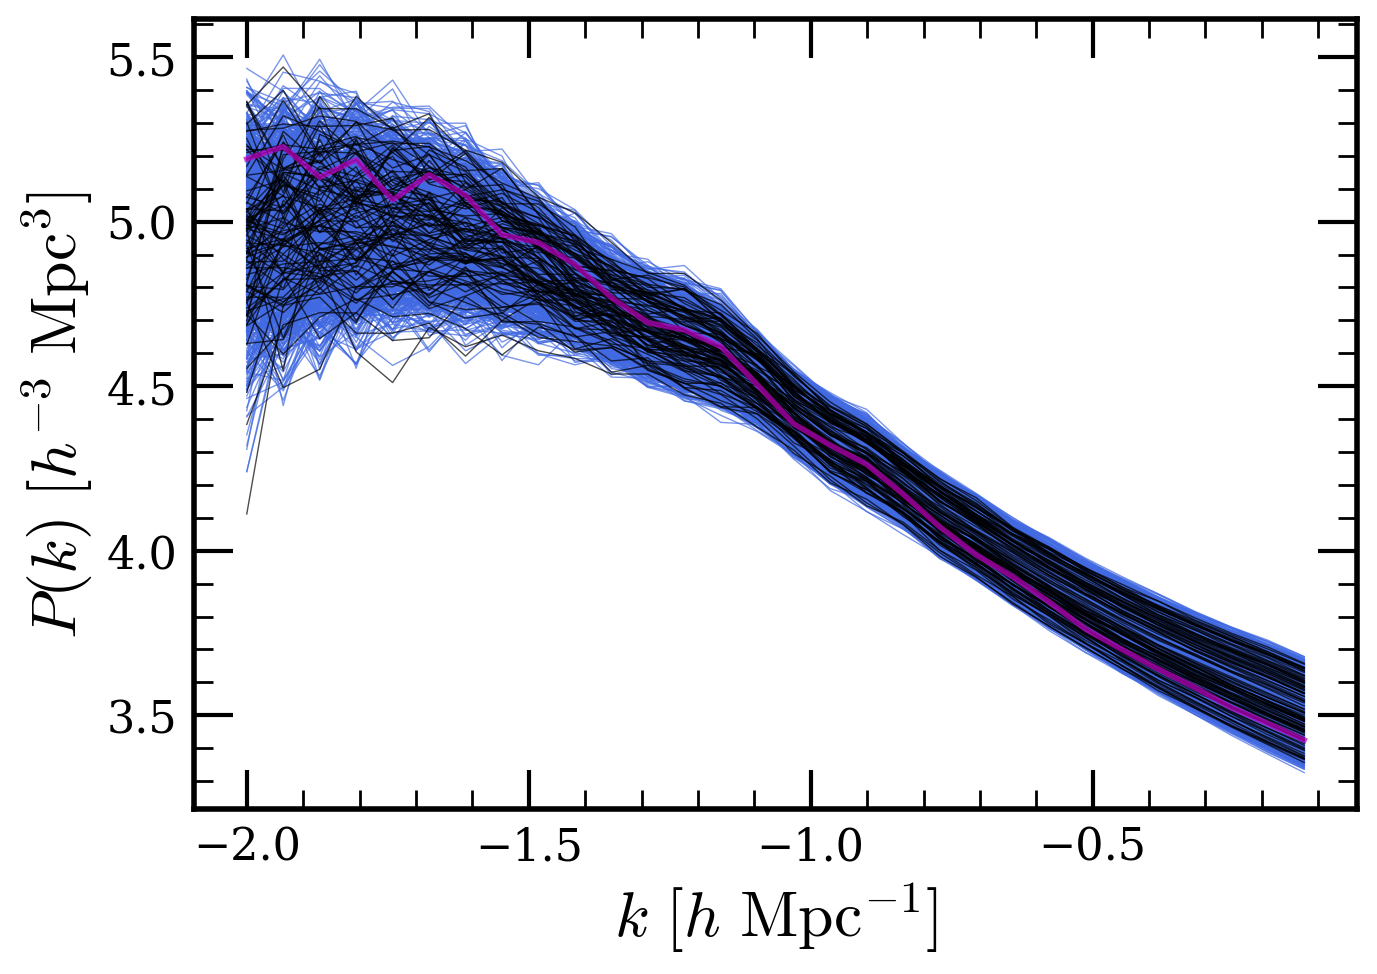

In [15]:
fig, ax = mpl.pyplot.subplots(1,1, figsize=(7,5))
fontsize = 24
fontsize1 = 18

alpha = 0.7

tmp_Pk_plot = Pk_train
tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='royalblue', alpha=alpha, lw=0.5, label='training set')

tmp_Pk_plot = Pk_test
tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='k', alpha=alpha, lw=0.5, label='test set')
    
ax.plot(np.log10(k), np.log10(Pk_test[0]), c='m', alpha=alpha, lw=2, label='test data')
    
ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [16]:
dict_bounds = {}
for pp, param_name in enumerate(param_names):
    dict_bounds[param_name] = [np.min(theta[:,pp]), np.max(theta[:,pp])]

In [17]:
class Scaler:

    def __init__(self):
        pass
        
    def fit(self, x_train):
        self.x_train_min = np.min(x_train)
        self.x_train_max = np.max(x_train)

    def scale(self, x):
        log_x = np.log10(x)
        log_x_norm = (log_x - np.log10(self.x_train_min)) / (np.log10(self.x_train_max) - np.log10(self.    x_train_min))
        return log_x_norm
    
    def unscale(self, x_scaled):
        x = x_scaled * (np.log10(self.x_train_max) - np.log10(self.x_train_min)) + np.log10(self.x_train_min)
        return 10**x  
    
    def scale_error(self, err, x):
        # need 1/np.log(10) factor bc working in base 10
        dydx = 1./x * 1/np.log(10) * 1./(np.log10(self.x_train_max) - np.log10(self.x_train_min))
        err_scaled = np.sqrt(np.multiply(dydx**2, err**2))
        return err_scaled
    
    def scale_log(self, x):
        return np.log10(x)
    
    def scale_log_error(self, err, x):
        return (1./x) * (1/np.log(10)) * err

ok gaussian error is not the same here...! check how bacco is measuring

In [18]:
scaler = Scaler()
scaler.fit(Pk_train)
Pk_train_scaled = scaler.scale(Pk_train)
Pk_val_scaled = scaler.scale(Pk_val)
Pk_test_scaled = scaler.scale(Pk_test)

gaussian_error_pk_train_scaled = scaler.scale_error(gaussian_error_pk_train, Pk_train)
gaussian_error_pk_val_scaled = scaler.scale_error(gaussian_error_pk_val, Pk_val)
gaussian_error_pk_test_scaled = scaler.scale_error(gaussian_error_pk_test, Pk_test)

In [19]:
print(np.min(Pk_train), np.max(Pk_train))
print(np.min(Pk_train_scaled), np.max(Pk_train_scaled))

print(np.min(Pk_test), np.max(Pk_test))
print(np.min(Pk_test_scaled), np.max(Pk_test_scaled))

2116.664702104725 320866.67053724825
0.0 1.0
2271.1452759751965 294957.7353519151
0.014029088327851895 0.9832323207493852


In [20]:
print(Pk_train.shape, theta_train.shape, n_params)

(800, 30) (800, 2) 2


In [21]:
err_extra = 0.2*np.std(Pk_train, axis=0)
err_extra_scaled = scaler.scale_error(err_extra, np.median(Pk_train, axis=0))    

### Set up emulator, visualize

Set up test model now so we can viz

In [22]:
idx_test = 17
pk_data = Pk_test_scaled[idx_test]

err_gaussian_scaled = gaussian_error_pk_test_scaled[idx_test]
var = err_gaussian_scaled**2
#var = err_gaussian_scaled**2 + err_extra_scaled**2
cov_inv = np.diag(1/var)


In [23]:
# def setup_cosmo_emu():
#     print("Setting up emulator cosmology")
#     cosmo_params = {
#         #'omega_cold'    :  Om,
#         #'sigma8_cold'   :  sigma8, # if A_s is not specified
#         'omega_baryon'  :  param_dict_fixed['omega_baryon'],
#         'ns'            :  param_dict_fixed['n_s'],
#         #'hubble'        :  hubble,
#         'neutrino_mass' :  0.0,
#         'w0'            : -1.0,
#         'wa'            :  0.0,
#         'expfactor'     :  1
#     }
#     return cosmo_params

In [24]:
emu_param_names = param_names

In [25]:
#emu = baccoemu.Lbias_expansion(verbose=False)
fn_emu = '/dipc_storage/cosmosims/data_share/lbias_emulator/lbias_emulator2.0.0'
emu = baccoemu.Lbias_expansion(verbose=False, 
                               nonlinear_emu_path=fn_emu,
                               nonlinear_emu_details='details.pickle',
                               nonlinear_emu_field_name='NN_n',
                               nonlinear_emu_read_rotation=False)
#cosmo_params = setup_cosmo_emu()
cosmo_params = genP.setup_cosmo_emu()
# TODO save and read bias params
bias_params = [1., 0., 0., 0.]

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2024-02-22 17:45:45.006618: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 48. Tune using inter_op_parallelism_threa

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII
Setting up emulator cosmology


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [26]:
# overall quantities
deltas_pk_per_err = []
deltas_pk_per_err_scaled = []
for i in range(Pk_train.shape[0]):
    # if i % 100 == 0:
    #     print(i)
    # for pp in range(len(param_names)):
    #     cosmo_params[emu_param_names[pp]] = theta[i][pp]
    # _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
    #                                                     **cosmo_params)
    # in this case the orig emu pks are what we want
    pk_model_unscaled = Pk_noiseless[:train_split][i]
    delta_pk_per_err = (pk_model_unscaled-Pk_train[i])/gaussian_error_pk_train[i]
    deltas_pk_per_err.append(delta_pk_per_err)
    
    pk_model = scaler.scale(pk_model_unscaled)
    delta_pk_per_err_scaled = (pk_model-Pk_train_scaled[i])/gaussian_error_pk_train_scaled[i]
    deltas_pk_per_err_scaled.append(delta_pk_per_err_scaled)
    
deltas_pk_per_err = np.array(deltas_pk_per_err)
delta_pk_per_err_16 = np.percentile(deltas_pk_per_err, 16, axis=0)
delta_pk_per_err_84 = np.percentile(deltas_pk_per_err, 84, axis=0)

deltas_pk_per_err_scaled = np.array(deltas_pk_per_err_scaled)
deltas_pk_per_err_scaled_16 = np.percentile(deltas_pk_per_err_scaled, 16, axis=0)
deltas_pk_per_err_scaled_84 = np.percentile(deltas_pk_per_err_scaled, 84, axis=0)

Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

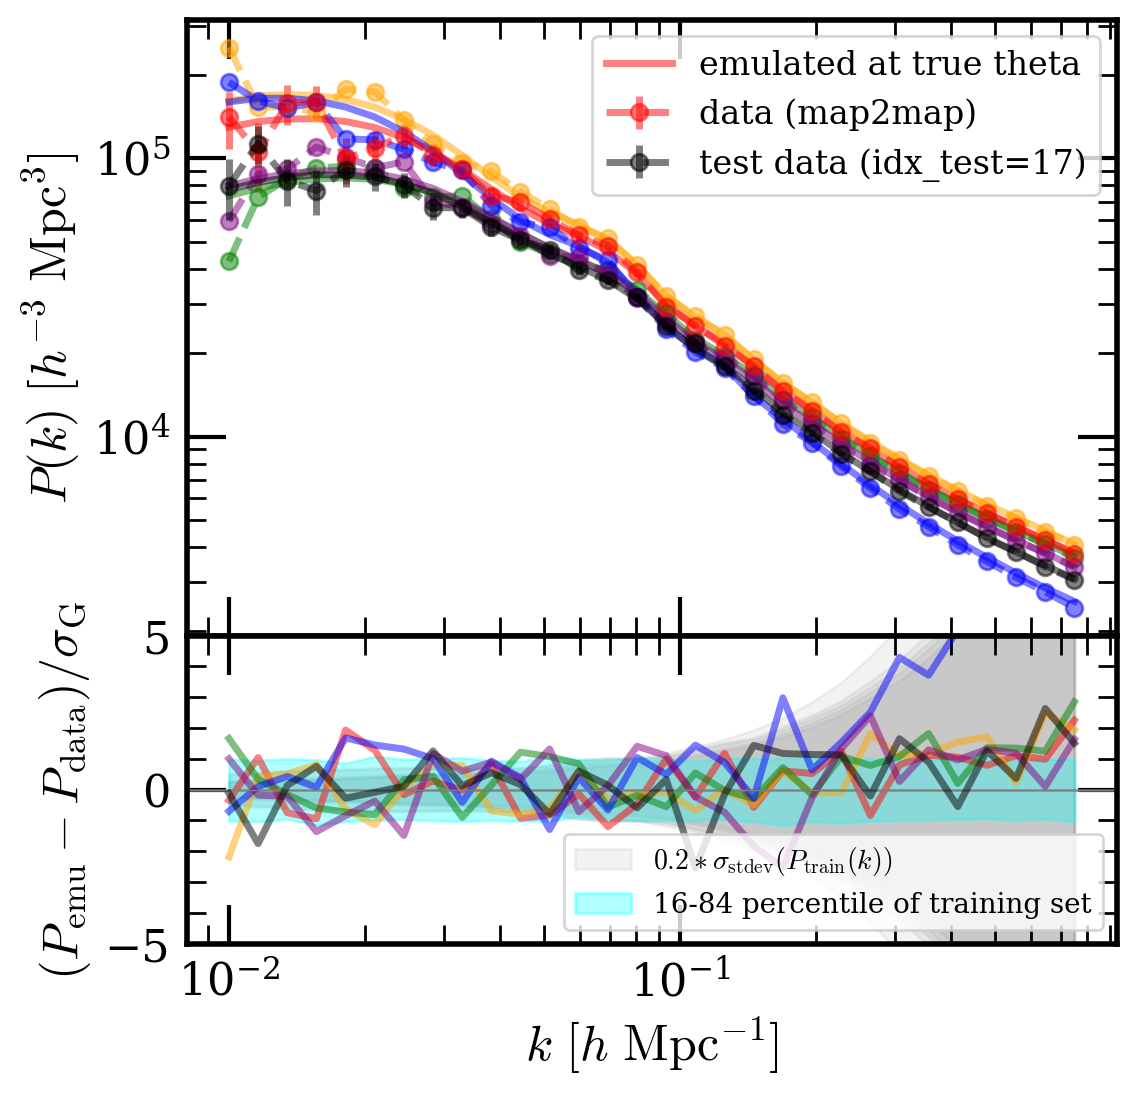

In [27]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)
    
# a few examples
colors = ['red', 'orange', 'green', 'blue', 'purple']
for i in range(5):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                        **cosmo_params)

    label_true, label_emu, label_stdev = None, None, None
    if i==0:
        label_true = 'data (map2map)'
        label_emu = 'emulated at true theta'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
    
    if i==0:
        axarr[0].errorbar(k, Pk_train[i], yerr=gaussian_error_pk_train[i], 
                          ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    else:
        axarr[0].plot(k, Pk_train[i], ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i])
    
    axarr[1].plot(k, (pk_model_unscaled-Pk_train[i])/gaussian_error_pk_train[i], ls='-', alpha=0.5, color=colors[i])
    axarr[1].axhline(0, color='grey', lw=0.5)
    axarr[1].fill_between(k, -err_extra/gaussian_error_pk_train[i], 
                              err_extra/gaussian_error_pk_train[i], color='grey', alpha=0.1,
                              label=label_stdev)

axarr[1].fill_between(k, delta_pk_per_err_16, delta_pk_per_err_84, color='cyan', alpha=0.3,
                      label='16-84 percentile of training set')

# test data
color_test = 'k'
for pp in range(len(param_names)):
    cosmo_params[emu_param_names[pp]] = theta_test[idx_test][pp]
_, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                 **cosmo_params)
axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, color=color_test)
axarr[0].errorbar(k, Pk_test[idx_test], yerr=gaussian_error_pk_test[idx_test], 
                  ls='--', marker='o', markersize=6, alpha=0.5, label=f'test data (idx_test={idx_test})', color=color_test)
axarr[1].plot(k, (pk_model_unscaled-Pk_test[idx_test])/gaussian_error_pk_test[idx_test], ls='-', alpha=0.5, color=color_test)

# plot settings
plt.xscale('log')
axarr[0].set_yscale('log')
    
axarr[1].set_ylim(-5, 5)
    
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=10)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

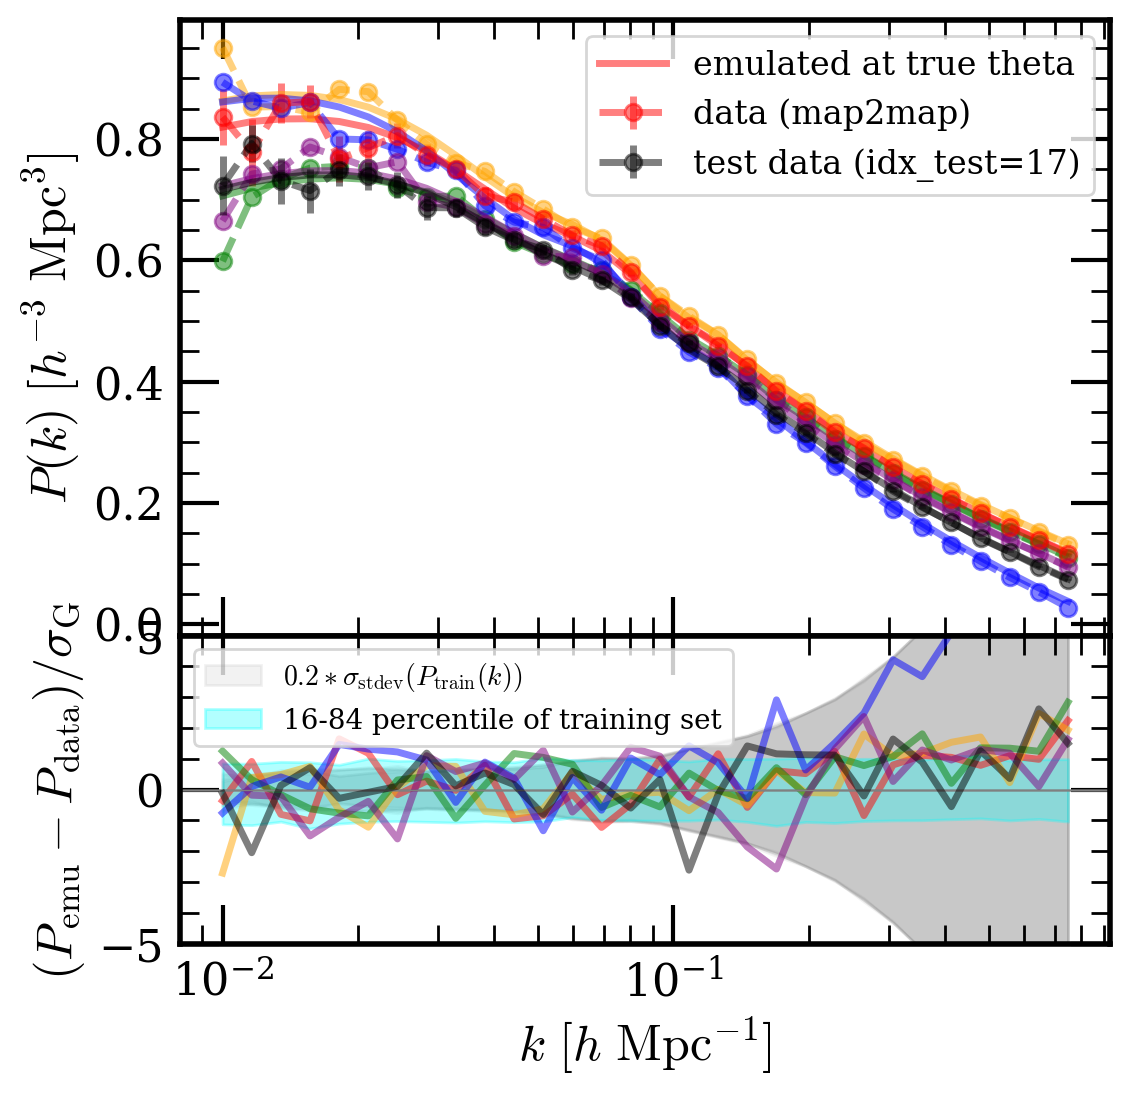

In [28]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)

colors = ['red', 'orange', 'green', 'blue', 'purple']

for i in range(5):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                        **cosmo_params)
    pk_model_scaled = scaler.scale(pk_model_unscaled)
    
    label_true, label_emu, label_stdev = None, None, None
    if i==0:
        label_true = 'data (map2map)'
        label_emu = 'emulated at true theta'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
    
    if i==0:
        axarr[0].errorbar(k, Pk_train_scaled[i], yerr=gaussian_error_pk_train_scaled[i], 
                          ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    else:
        axarr[0].plot(k, Pk_train_scaled[i], ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    axarr[0].plot(k, pk_model_scaled, ls='-', alpha=0.5, label=label_emu, color=colors[i])
    
    axarr[1].plot(k, (pk_model_scaled-Pk_train_scaled[i])/gaussian_error_pk_train_scaled[i], ls='-', alpha=0.5, color=colors[i])
    axarr[1].axhline(0, color='grey', lw=0.5)    
    
    axarr[1].fill_between(k, -err_extra_scaled/gaussian_error_pk_train_scaled[i], 
                              err_extra_scaled/gaussian_error_pk_train_scaled[i], color='grey', alpha=0.1,
                              label=label_stdev)

axarr[1].fill_between(k, deltas_pk_per_err_scaled_16, deltas_pk_per_err_scaled_84, color='cyan', alpha=0.3,
                      label='16-84 percentile of training set')

# test data
color_test = 'k'
for pp in range(len(param_names)):
    cosmo_params[emu_param_names[pp]] = theta_test[idx_test][pp]
_, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                 **cosmo_params)
pk_model_scaled = scaler.scale(pk_model_unscaled)

axarr[0].plot(k, pk_model_scaled, ls='-', alpha=0.5, color=color_test)
axarr[0].errorbar(k, Pk_test_scaled[idx_test], yerr=gaussian_error_pk_test_scaled[idx_test], 
                  ls='--', marker='o', markersize=6, alpha=0.5, label=f'test data (idx_test={idx_test})', color=color_test)
axarr[1].plot(k, (pk_model_scaled-Pk_test_scaled[idx_test])/gaussian_error_pk_test_scaled[idx_test], ls='-', alpha=0.5, color=color_test)

# plot settings

plt.xscale('log')
#axarr[0].set_yscale('log')
    
axarr[1].set_ylim(-5, 5)
    
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=10)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


### Set up and train Moment Network model

Following demos at https://github.com/NiallJeffrey/MomentNetworks/tree/master

In [29]:
model_instance = demo.simple_leaky(n_dim, n_params, 
                                   learning_rate=1e-3) 
regression = model_instance.model() 

30
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 30)                930       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                1860      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1830      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 30)                0  

Train initial model (basic MLP), as usual, on labeled data

In [30]:
history = regression.fit(Pk_train_scaled, theta_train,
                         epochs=1000, batch_size=32, shuffle=True,
                         validation_data=(Pk_val_scaled, theta_val))

Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.3156 - val_loss: 0.1667
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0409 - val_loss: 0.0032
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.002

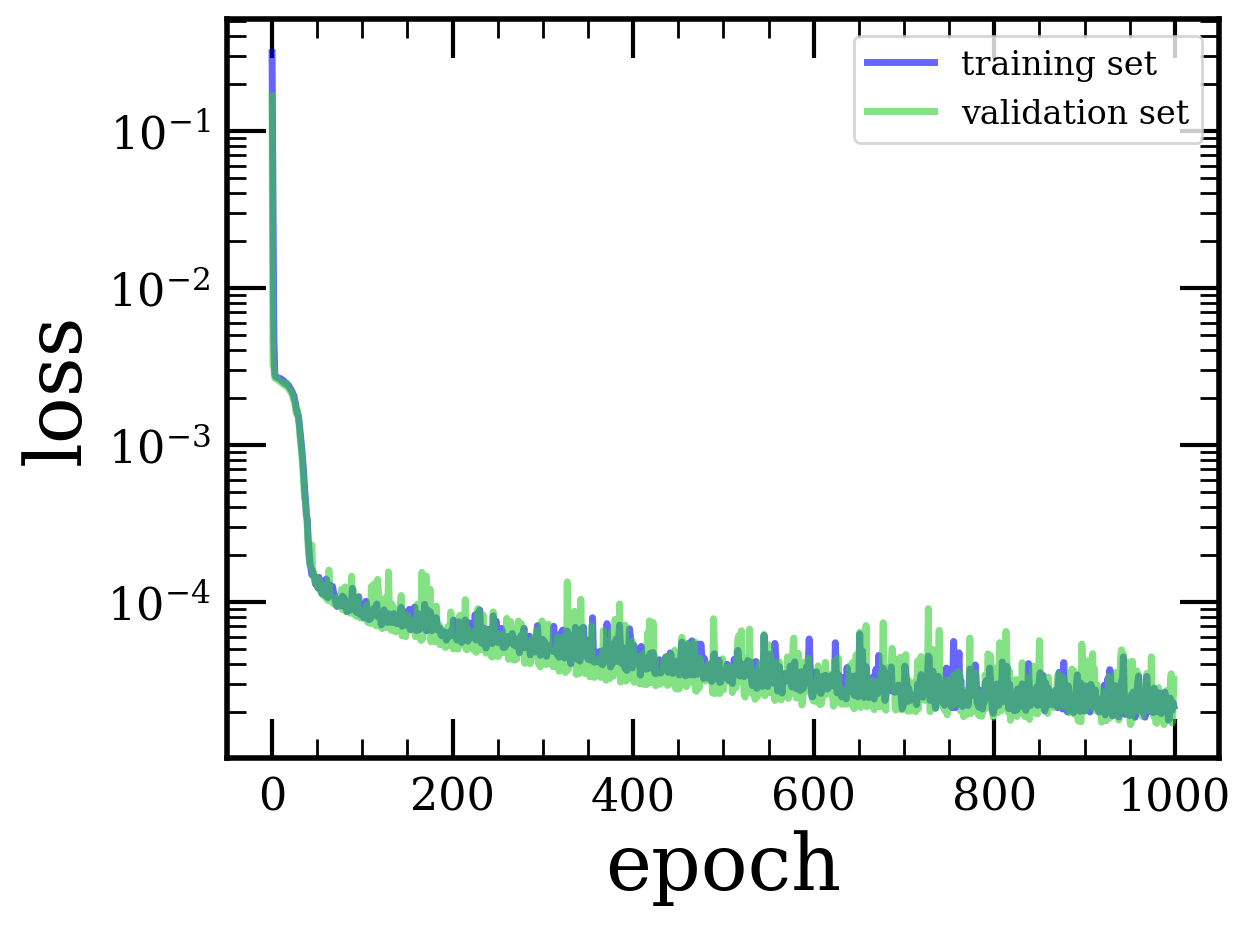

In [31]:
plt.plot(history.history['loss'], color='blue', label='training set', alpha=0.6)
plt.plot(history.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
plt.legend(fontsize=12)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.yscale('log')
#plt.ylim(0, 0.005)

In [32]:
theta_train_pred = regression.predict(np.atleast_2d(Pk_train_scaled))
theta_val_pred = regression.predict(np.atleast_2d(Pk_val_scaled))

4/4 [==============================] - 0s 1ms/step


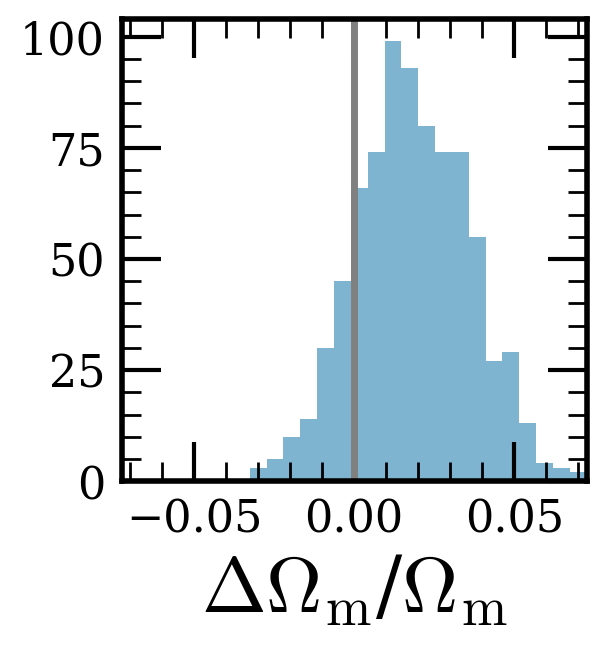

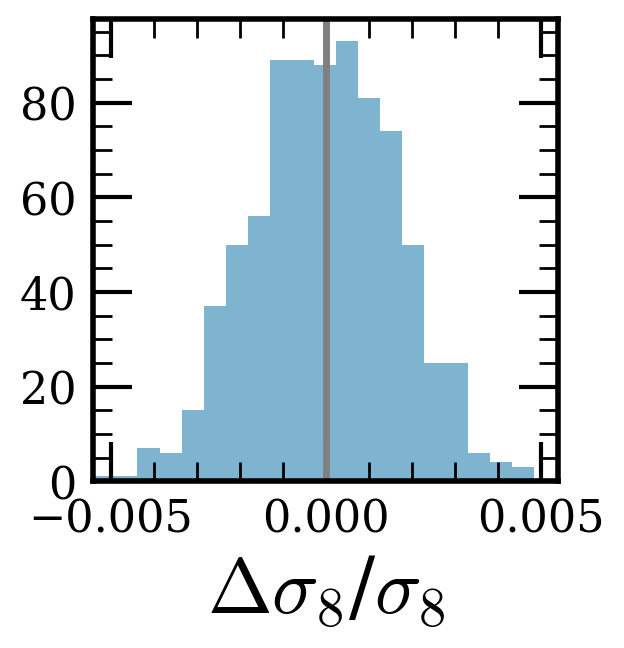

In [36]:
for pp in range(n_params):
    plt.figure(figsize=(3,3))
    delta_param = (theta_train_pred[:,pp] - theta_train[:,pp])/theta_train[:,pp]
    plt.hist(delta_param, bins=20, alpha=0.5)
    plt.xlabel(rf'$\Delta${param_labels[pp]}/{param_labels[pp]}')
    plt.axvline(0, color='grey')
    plt.xlim(-np.max(abs(delta_param)), np.max(abs(delta_param)))

Get means and residuals

In [37]:
cov_dict = {}

training_covariances = []
training_covariances_val = []
count = 0
for i in range(n_params):
    for j in range(n_params):
        if j<i:
            cov_dict[(i,j)] = cov_dict[(j,i)]
            continue
        training_cov = ((theta_train[:,i]-theta_train_pred[:,i])* \
                        (theta_train[:,j]-theta_train_pred[:,j]))
        training_covariances.append(training_cov)
        
        training_cov_val = ((theta_val[:,i]-theta_val_pred[:,i])* \
                            (theta_val[:,j]-theta_val_pred[:,j]))
        training_covariances_val.append(training_cov_val)
        
        cov_dict[(i,j)] = count
        count += 1
        
training_covariances = np.array(training_covariances).T
training_covariances_val = np.array(training_covariances_val).T

n_covs = training_covariances.shape[1]

In [38]:
def compute_cov_predmean(theta, theta_pred):
    cov = np.empty((theta.shape[1], theta.shape[1]))
    n_samples = theta.shape[0]
    for pp_i in range(theta.shape[1]):
        for pp_j in range(theta.shape[1]):
            val = 0
            for i in range(n_samples):
                val += (theta[i][pp_i] - theta_pred[i][pp_i])*(theta[i][pp_j] - theta_pred[i][pp_j])
            cov[pp_i,pp_j] = val/n_samples
    return cov

def compute_cov_truemean(theta, bias=False):
    cov = np.empty((theta.shape[1], theta.shape[1]))
    theta_means = np.mean(theta, axis=0)
    n_samples = theta.shape[0]
    if bias:
        norm = n_samples
    else:
        norm = n_samples - 1
    for pp_i in range(theta.shape[1]):
        for pp_j in range(theta.shape[1]):
            val = 0
            for i in range(n_samples):
                val += (theta[i][pp_i] - theta_means[pp_i])*(theta[i][pp_j] - theta_means[pp_j])
            cov[pp_i,pp_j] = val/norm
    return cov

In [59]:
model_instance = demo.simple_leaky(n_dim, n_covs, learning_rate=None)
regression_var_unknown_mean = model_instance.model()

30
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_12 (Dense)            (None, 30)                930       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30)                0         
                                                                 
 dense_13 (Dense)            (None, 60)                1860      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 60)                0         
                                                                 
 dense_14 (Dense)            (None, 30)                1830      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 30)                0

In [60]:
np.mean(training_covariances, axis=0), np.std(training_covariances, axis=0)

(array([6.10293494e-05, 4.12198092e-06, 1.85238809e-06]),
 array([7.34546696e-05, 1.22906001e-05, 2.58623089e-06]))

In [61]:
history_var = regression_var_unknown_mean.fit(Pk_train_scaled,
                                          training_covariances,
                                          epochs=1000, batch_size=32, shuffle=True,
                                          validation_data = (Pk_val_scaled,
                                                             training_covariances_val))

Epoch 1/1000
25/25 [==============================] - 1s 12ms/step - loss: 2.1060e-07 - val_loss: 6.2123e-08
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 1.8005e-08 - val_loss: 6.8439e-09
Epoch 3/1000
25/25 [==============================] - 0s 5ms/step - loss: 5.2448e-09 - val_loss: 4.3813e-09
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 4.0864e-09 - val_loss: 4.1931e-09
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 3.3244e-09 - val_loss: 3.3643e-09
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 2.8755e-09 - val_loss: 3.4883e-09
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 3.1211e-09 - val_loss: 2.9719e-09
Epoch 8/1000
25/25 [==============================] - 0s 5ms/step - loss: 2.7977e-09 - val_loss: 3.8223e-09
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 2.6631e-09 - val_loss: 2.8753e-09
Epoch 10/1000
25/25 [======

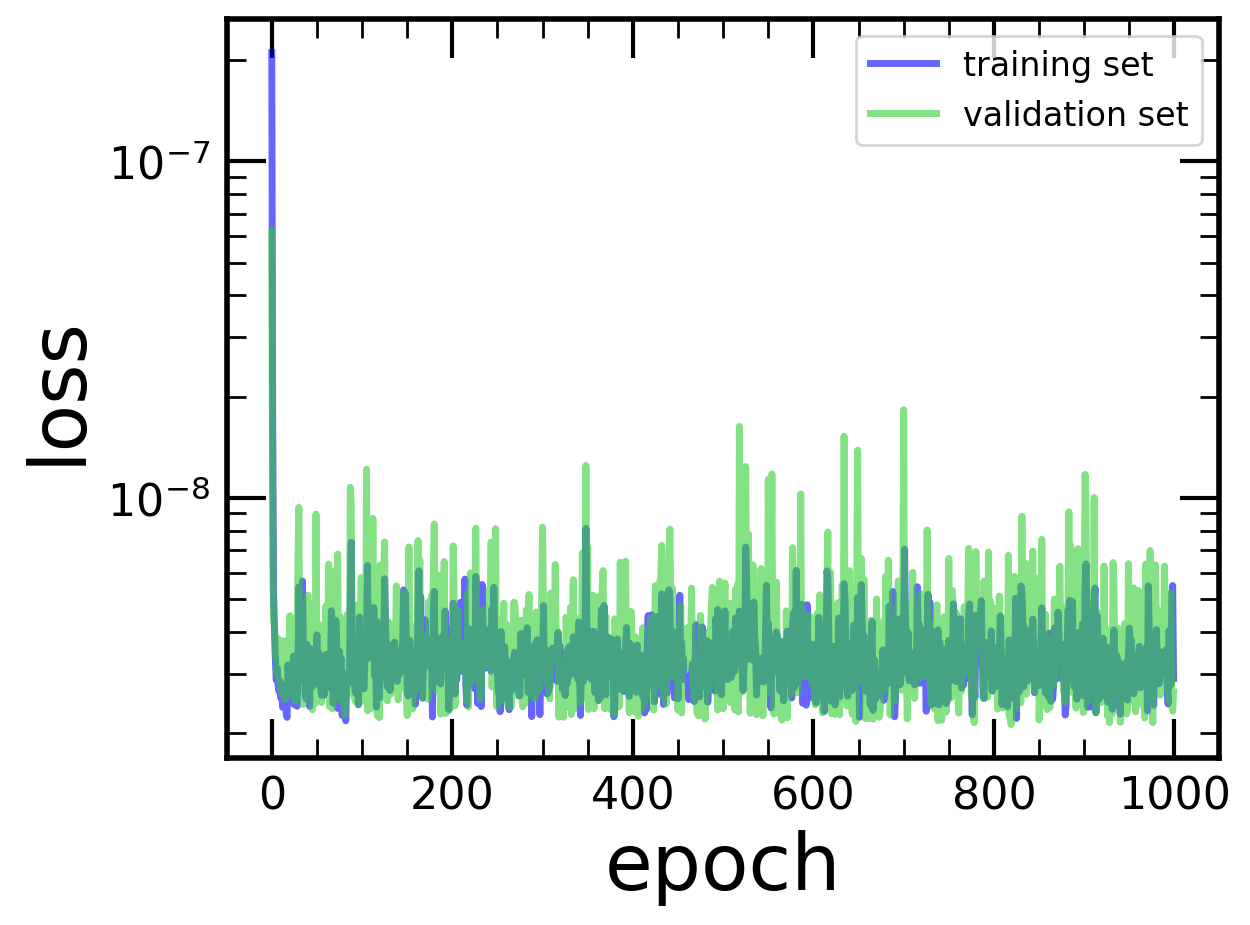

In [62]:
plt.plot(history_var.history['loss'], color='blue', label='training set', alpha=0.6)
plt.plot(history_var.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
plt.legend(fontsize=12)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.yscale('log')
#plt.ylim(0, 0.005)

### Explicit likelihood setup

In [42]:
# for emcee
n_burn = 40
n_steps = 200 # 50000
n_walkers = 4 * n_params

In [43]:
# for emcee
def log_prior(theta):
    for pp in range(len(param_names)):
       if (theta[pp] < dict_bounds[param_names[pp]][0]) or (theta[pp] >= dict_bounds[param_names[pp]][1]):
           return -np.inf
    return 0.0

# for dynesty
def prior_transform(u):

    u_transformed = []
    for pp in range(len(param_names)):
        width = dict_bounds[param_names[pp]][1] - dict_bounds[param_names[pp]][0]
        min_bound = dict_bounds[param_names[pp]][0]
        
        u_t = width*u[pp] + min_bound
        u_transformed.append(u_t)           

    return np.array(u_transformed)

In [44]:
global pk_data, cov_inv

def log_likelihood(theta):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                **cosmo_params)
    pk_model = scaler.scale(pk_model_unscaled)
    diff = pk_data-pk_model
    # print(theta)
    # print(cosmo_params)
    # print(pk_data)
    # print(pk_model)
    # print(cov_inv[0,0], cov_inv[1,1], cov_inv[2,2])
    # print(-0.5*np.dot(diff,np.dot(cov_inv,diff)))
    
    # print()
    return -0.5*np.dot(diff,np.dot(cov_inv,diff))

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [45]:
n_threads = 8

### Test on a model from the test set (held-out data)

Moment network:

In [46]:
predicted_mean_obs_test = regression.predict(np.atleast_2d(pk_data))
print(predicted_mean_obs_test)

predicted_var_obs_test = (regression_var_unknown_mean.predict(np.atleast_2d(pk_data))[0])
moment_network_param_cov_test = np.empty((n_params, n_params))
for i in range(n_params):
    for j in range(n_params):
        moment_network_param_cov_test[i,j] = predicted_var_obs_test[cov_dict[(i,j)]]
print(moment_network_param_cov_test)

1/1 [==============================] - 0s 25ms/step
[[0.33375034 0.7993472 ]]
1/1 [==============================] - 0s 70ms/step
[[ 9.26838620e-05 -2.08484998e-05]
 [-2.08484998e-05  1.01901896e-05]]


In [47]:
moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],
                                       moment_network_param_cov_test,int(1e6)),dtype=np.float32)
gc.collect()

12953

In [48]:
np.cov(moment_network_samples_test.T)

array([[ 9.27146598e-05, -2.08636291e-05],
       [-2.08636291e-05,  1.02093968e-05]])

MCMC, Dynesty:

In [49]:
with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:
    sampler_test = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
                                         nlive=20, bound='single')
    sampler_test.run_nested(dlogz=0.01)

235it [01:31,  2.58it/s, +20 | bound: 16 | nc: 1 | ncall: 1085 | eff(%): 23.944 | loglstar:   -inf < -12.568 <    inf | logz: -19.406 +/-  0.529 | dlogz:  0.000 >  0.010]


In [50]:
results_test = sampler_test.results
samples_dynesty_test = results_test.samples_equal()
print(samples_dynesty_test.shape)

(255, 2)


MCMC, emcee:

In [51]:
run_emcee = False
if run_emcee:
    rng = np.random.default_rng(seed=42)
    theta_0 = np.array([[rng.uniform(low=dict_bounds[param_name][0],high=dict_bounds[param_name][1]) 
                        for param_name in param_names] for _ in range(n_walkers)])

    start = time.time()
    if n_threads>1:
        with Pool(processes=n_threads) as pool:
            sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool)
            _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    else:
        sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior)
        _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    end = time.time()

    print(f"Time: {end-start} s ({(end-start)/60} min)")

    samples_emcee = sampler_emcee.get_chain(discard=n_burn, flat=True, thin=1)
    gc.collect()

### Plot contours

Is there a "true" covariance in this toy case i can compare to?!?

The cov i input is in the data space, not the parameter space...

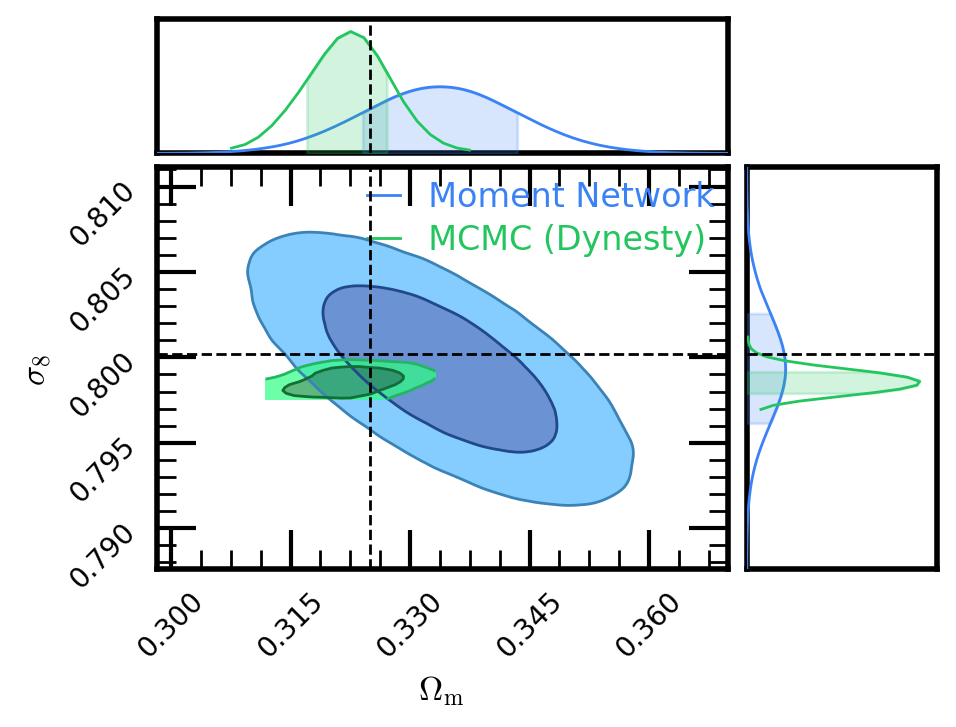

In [56]:
c = chainconsumer.ChainConsumer()

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(moment_network_samples_test, columns=param_names),
            name='Moment Network', color='blue')
            )

if run_emcee:
    c.add_chain(chainconsumer.Chain(
                samples=pd.DataFrame(samples_emcee, columns=param_names),
                name='MCMC (emcee)', color='purple', ls='--',
                smooth=1, bins=10)
                )

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(samples_dynesty_test, columns=param_names),
            name='MCMC (Dynesty)', color='green', 
            smooth=2, bins=5)
            )

c.set_plot_config(
    chainconsumer.PlotConfig(
        flip=True,
        labels=param_label_dict,
        contour_label_font_size=12,
        #extents=dict_bounds,
    )
)

truth_loc = dict(zip(param_names, theta_test[idx_test]))
c.add_truth(chainconsumer.Truth(location=truth_loc))

fig = c.plotter.plot(figsize = (5,4) )
if save_plots:
    plt.savefig(f'{plot_dir}/contours_test{idx_test}{tag_emuPk}{tag_fit}.png')

### For all test data

In [94]:
sigmas_from_truth = []
theta_test_pred = regression.predict(Pk_test_scaled)
vars_test_pred = regression_var_unknown_mean.predict(Pk_test_scaled)
#print(theta_pred_test.shape, vars_pred_test.shape)

for i in range(Pk_test_scaled.shape[0]):
    pk_data_test = Pk_test_scaled[i]
    
    moment_network_param_cov_test = np.empty((n_params, n_params))
    for ii in range(n_params):
        for jj in range(n_params):
            moment_network_param_cov_test[ii,jj] = vars_pred_test[i][cov_dict[(ii,jj)]]
    
    # just doing for variances now, not covariance
    #print(theta_test_pred[i])
    #print(theta_test[i])
    #print(moment_network_param_cov_test)
    err = np.sqrt(np.diag(moment_network_param_cov_test))
    #print(err)
    sigma_from_truth = (theta_test[i] - theta_test_pred[i])/err
    sigmas_from_truth.append(sigma_from_truth)
    #print(sigma_from_truth)
sigmas_from_truth = np.array(sigmas_from_truth)

4/4 [==============================] - 0s 1ms/step


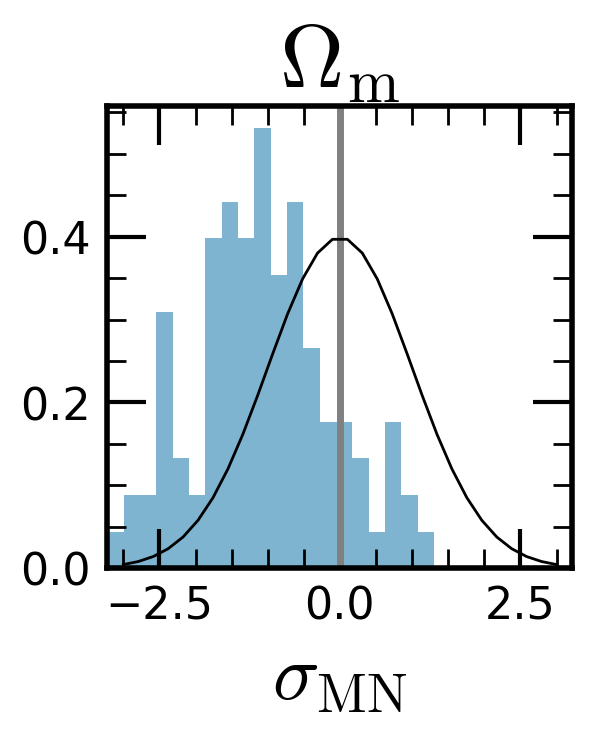

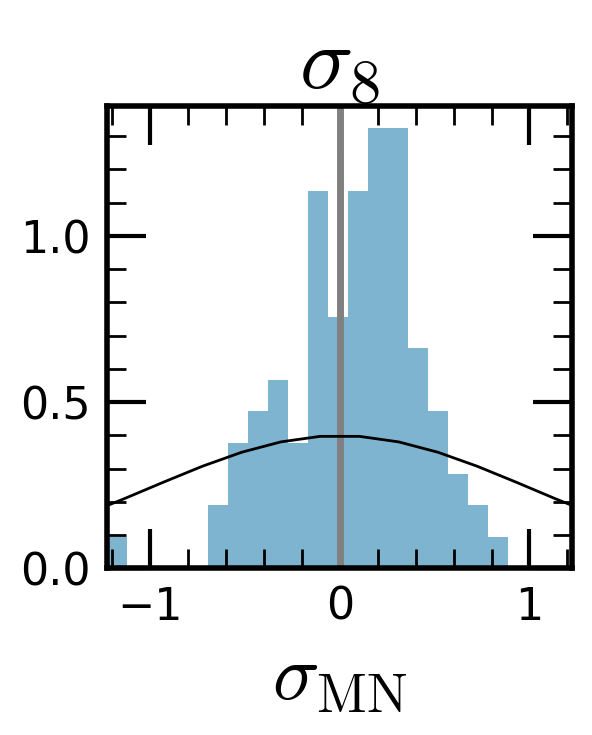

In [110]:
x_normal = np.linspace(-3, 3, 30)
mean, variance = 0, 1
y_normal = np.exp(-np.square(x_normal-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
for pp in range(n_params):
    plt.figure(figsize=(3,3))
    plt.title(rf'{param_labels[pp]}')
    plt.hist(sigmas_from_truth[:,pp], bins=20, alpha=0.5, density=True)
    plt.xlabel(r'$\sigma_\text{MN}$')
    plt.axvline(0, color='grey')
    plt.xlim(-np.max(abs(sigmas_from_truth[:,pp])), np.max(abs(sigmas_from_truth[:,pp])))
    
    plt.plot(x_normal, y_normal, color='black', lw=1)

### Try another test model

In [ ]:
idx_test = 8
pk_data = Pk_test_scaled[idx_test]

Moment network:

In [ ]:
predicted_mean_obs_test = regression.predict(np.atleast_2d(pk_data))
predicted_var_obs_test = (regression_var_unknown_mean.predict(np.atleast_2d(pk_data))[0])

moment_network_param_cov_test = np.empty((n_params, n_params))

for i in range(n_params):
    for j in range(n_params):
        moment_network_param_cov_test[i,j] = predicted_var_obs_test[cov_dict[(i,j)]]
print(moment_network_param_cov_test)

In [ ]:
moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],
                                  moment_network_param_cov_test,int(1e6)),dtype=np.float32)
gc.collect()

MCMC, Dynesty:

In [ ]:
with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:
    sampler_test = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
                                         nlive=20, bound='single')
    sampler_test.run_nested(dlogz=0.01)

In [ ]:
results_test = sampler_test.results
samples_dynesty_test = results_test.samples_equal()
print(samples_dynesty_test.shape)

MCMC, emcee:

In [ ]:
run_emcee = False
if run_emcee:
    rng = np.random.default_rng(seed=42)
    theta_0 = np.array([[rng.uniform(low=dict_bounds[param_name][0],high=dict_bounds[param_name][1]) 
                        for param_name in param_names] for _ in range(n_walkers)])

    start = time.time()
    if n_threads>1:
        with Pool(processes=n_threads) as pool:
            sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool)
            _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    else:
        sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior)
        _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    end = time.time()

    print(f"Time: {end-start} s ({(end-start)/60} min)")

    samples_emcee = sampler_emcee.get_chain(discard=n_burn, flat=True, thin=1)
    gc.collect()

### Plot contours

In [ ]:
c = chainconsumer.ChainConsumer()

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(moment_network_samples_test, columns=param_names),
            name='Moment Network', color='blue')
            )

if run_emcee:
    c.add_chain(chainconsumer.Chain(
                samples=pd.DataFrame(samples_emcee, columns=param_names),
                name='MCMC (emcee)', color='purple', ls='--',
                smooth=1, bins=10)
                )

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(samples_dynesty_test, columns=param_names),
            name='MCMC (Dynesty)', color='green', 
            smooth=2, bins=5)
            )

c.set_plot_config(
    chainconsumer.PlotConfig(
        flip=True,
        labels=param_label_dict,
        contour_label_font_size=12,
        #extents=dict_bounds,
    )
)

truth_loc = dict(zip(param_names, theta_test[idx_test]))
c.add_truth(chainconsumer.Truth(location=truth_loc))

fig = c.plotter.plot(figsize = (5,4) )
if save_plots:
    plt.savefig(f'{plot_dir}/contours_test{idx_test}{tag_emuPk}{tag_fit}.png')